In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from scipy.special import boxcox, inv_boxcox
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import statsmodels.api as sm
import xgboost as xgb
import warnings
import scipy.stats as stats
import statsmodels.api as sm
import pylab
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/rachelfein/opt/anaconda3/envs/predictive-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## End of preprocessing notebook, next notebook is modeling

In [2]:
# Import df from EDA & Preprocessing Notebook
X_train = pd.read_csv('Data/X_train_ol.csv')
X_test = pd.read_csv('Data/X_test_ol.csv')
y_train = pd.read_csv('Data/y_train_ol.csv')
y_test = pd.read_csv('Data/y_test_ol.csv')


# Baseline Model
Linear Regression

Next we will make a funtion to evaluate our model's performance. A breif overview of the different metrics:
- Mean Absolute Error (MAE): A basic metric that gives us the absolute difference between actual and predicted values. Idealy the final model would have a smaller MAE than the baseline model since we aim to lower the amount of error by tuning models.
- Mean Squared Error (MSE): Finds the squared difference between the actual and predicted values. The MSE is helpful since it avoids the cancellation of negative terms (unlike MAE). However, outliers will be more damaging since it penalizes the outliers more than MAE. 
- Root Mean Square Error(RMSE): Is the square root of the MSE. RMSE is easier to interpret than MSE since the output is in the same units as the variable
- R Squared (R2): A metric that tells the performance of the model, unlike the others which show the loss. This is a metric that is best for comparing the different models. R2 will be a value betweet 0 and 1, with 1 being a perfect fit.

In [3]:
# make scaler for y_train
scaler_y = StandardScaler()
# make scaler for X_train
scaler = StandardScaler()

# fit X_train
scaler.fit(X_train)
# fit y_train
scaler_y.fit(y_train)

StandardScaler()

In [4]:
def diagnostic_inv(model, X_test, y_test):
    
    # get prediction on X_test
    test_pred = model.predict(X_test)
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,0.10417087))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')

In [5]:
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

diagnostic_inv(lr_base, X_test, y_test)

Test Mean Absolute Error : 233.55
Test Mean Squared Error: 112114.52
Test Root Mean Square Error :$ 334.84


To rely on a linear regression model it must meet the assumptions of linear regression. We will take a look at the assuptions next, 

In [6]:
# get residuals to look at assumptions of linear regression
test_pred = lr_base.predict(X_test)
residuals = y_test - test_pred

<AxesSubplot:ylabel='Density'>

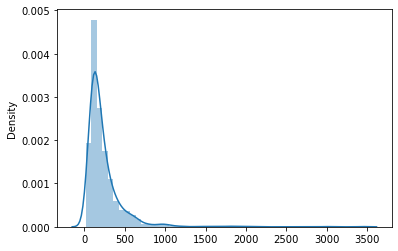

In [7]:
# look at normailty: the residuals of the Linear regression model are skewed
warnings.filterwarnings('ignore')
sns.distplot(residuals)

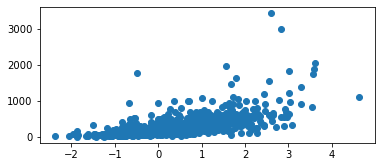

In [8]:
#The residuals do show a slight cone shape pattern 
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(test_pred, residuals)

In [9]:
# Double check for multicollinearity
X = X_train[['maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                       feature       VIF
0               maximum_nights  1.008808
1              availability_30  1.272208
2             availability_365  1.272150
3            number_of_reviews  1.114762
4         review_scores_rating  3.921225
5    review_scores_cleanliness  2.327897
6        review_scores_checkin  2.054911
7  review_scores_communication  2.425913
8       review_scores_location  1.347391
9          review_scores_value  2.215387


We see the baseline model has a R2 score of 0.25 which indicates it is a very poor performing model. 

## Model 2
In regression there are many different model types to choose from. Next, I am going to try a Random Forrest Model which is a little more robust to outliers than a Linear Regression model is. 

In [10]:
# Import Random Forest
forest_baseline = RandomForestRegressor()
forest_baseline.fit(X_train, y_train.values.ravel())

diagnostic_inv(forest_baseline, X_test, y_test)


Test Mean Absolute Error : 233.58
Test Mean Squared Error: 112279.36
Test Root Mean Square Error :$ 335.08


The RandomForest model did much worse than the linear regression model

In [15]:
# Use gridsearch to find a better RandomForest model
# I will start with a spread of different parameter options

param = {
    'criterion': ['squared_error'],
    'max_depth': [10, 50, 75],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
}


gridsearch_rf1 = GridSearchCV(estimator=forest_baseline,
                          param_grid=param, cv= 3, scoring='neg_mean_squared_error')

# Run search & takes a min or two
gridsearch_rf1.fit(X_train, y_train.values.ravel())
gridsearch_rf1.best_params_

{'criterion': 'squared_error',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 5}

In [16]:
results = pd.DataFrame(gridsearch_rf1.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
print(results.shape)

results.head(2)

(54, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.820353,0.010693,0.016310,0.000562,squared_error,75,auto,10,5,"{'criterion': 'squared_error', 'max_depth': 75...",-0.400907,-0.456423,-0.474814,-0.444048,0.031416,1
1,0.810430,0.009488,0.015656,0.000163,squared_error,50,auto,10,2,"{'criterion': 'squared_error', 'max_depth': 50...",-0.402161,-0.457773,-0.472313,-0.444082,0.030231,2


Text(0.5, 0, 'Hyperparameter combinations')

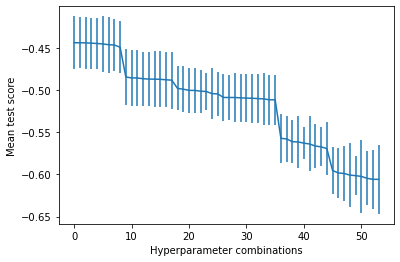

In [17]:
# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [18]:
diagnostic_inv(gridsearch_rf1, X_test, y_test)

Test Mean Absolute Error : 233.65
Test Mean Squared Error: 112494.43
Test Root Mean Square Error :$ 335.4


A little better than the baseline Randomforest model but still the linear regression model performed better.
We know from data exploration (in the EDA & Preprocessing notebook) that the data is skewed so we can try to prep the data some more and see if that helps. We can try to do a log transformation.

## Model 4
XGBoost

In [19]:

warnings.filterwarnings('ignore')

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

diagnostic_inv(xgbr, X_test, y_test)


Test Mean Absolute Error : 233.34
Test Mean Squared Error: 112183.69
Test Root Mean Square Error :$ 334.94


In [21]:
#regressor=xgb.XGBRegressor()

In [20]:
# block warning about not deprecated int64
warnings.filterwarnings('ignore')

param_grid = {"max_depth":    [5, 6, 7],
              "n_estimators": [600, 700, 800],
              "learning_rate": [0.01, 0.015, 0.25]}

xgb_search = GridSearchCV(xgbr, param_grid, cv=3, scoring='neg_mean_squared_error').fit(X_train, y_train)

# Run search & takes a min or two
xgb_search.fit(X_train, y_train.values.ravel())
xgb_search.best_params_

{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 800}

In [21]:
diagnostic_inv(xgb_search, X_test, y_test)

Test Mean Absolute Error : 233.5
Test Mean Squared Error: 112266.87
Test Root Mean Square Error :$ 335.06


In [46]:
# make basic decision tree model
from sklearn.tree import DecisionTreeRegressor

tree_baseline = DecisionTreeRegressor()
tree_baseline.fit(X_train, y_train)

diagnostic_inv(tree_baseline,X_test,y_test)

Test Mean Absolute Error : 233.1
Test Mean Squared Error: 112135.61
Test Root Mean Square Error :$ 334.87


## Using Feature Selection to Improve Model
Feature selection algorithms can be seen as a combination of search techniques for suggesting which features to use in a model. In the Preprocessing notebook filter methods were used for feature selection, such as looking at corrilation. 

First atempt to use only the features with a significant F score for xgboost model and the linear regression model since those are our best performing models. Lastly, we will use the LASSO method which is an embedded feature selection method, meaning feature selection is performed during the modeling algorithm's execution. 

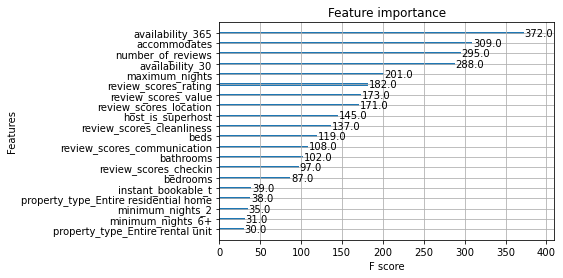

In [22]:
from xgboost import plot_importance
plot_importance(xgbr, max_num_features=20) # top 10 most important features
plt.show()

In [23]:
from sklearn.feature_selection import SelectFromModel
find_features = SelectFromModel(xgb.XGBRegressor(n_estimators=128, random_state=10))
find_features.fit(X_train, y_train)

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       enable_categorical=False, gamma=None,
                                       gpu_id=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_delta_step=None,
                                       max_depth=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=128, n_jobs=None,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=10, reg_alpha=None,
                                       reg_lambda=None, scale_pos

In [24]:
selected_features = X_train.columns[(find_features.get_support())]
len(selected_features)

30

In [25]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_features)))

print(
    'features with coef greater than the mean coef: {}'.format(
        np.sum(find_features.estimator_.feature_importances_ >
               find_features.estimator_.feature_importances_.mean())))

total features: 127
selected features: 30
features with coef greater than the mean coef: 30


In [26]:
def diagnostic_inv_fs(model, sel_test, y_test):
    
    # get prediction on X_test
    test_pred = model.predict(sel_test)
    
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,0.10417087))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')

In [27]:
sel_train = X_train[selected_features]
sel_test = X_test[selected_features]

In [28]:
xgbr = xgb.XGBRegressor()
xgbr.fit(sel_train, y_train)

diagnostic_inv_fs(xgbr, sel_test, y_test)

Test Mean Absolute Error : 233.35
Test Mean Squared Error: 112202.1
Test Root Mean Square Error :$ 334.97


### Using feature importance for XGB model did not help model performance. Next, lets try feature selection with the linear regression model

In [29]:
sel_linear = SelectFromModel(LinearRegression())

sel_linear.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression())

In [30]:
# let's count the number of variables selected
selected_feat_linear = X_train.columns[(sel_linear.get_support())]

len(selected_feat_linear)

45

In [31]:
print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat_linear)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_linear.estimator_.coef_) > np.abs(
                sel_linear.estimator_.coef_).mean())))

total features: 127
selected features: 45
features with coefficients greater than the mean coefficient: 45


In [32]:
sel_train = X_train[selected_feat_linear]
sel_test = X_test[selected_feat_linear]

In [33]:
sel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 45 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   accommodates                                    3250 non-null   float64
 1   bathrooms                                       3250 non-null   float64
 2   bedrooms                                        3250 non-null   float64
 3   availability_30                                 3250 non-null   float64
 4   review_scores_rating                            3250 non-null   float64
 5   review_scores_value                             3250 non-null   float64
 6   neighbourhood_Bayou St. John                    3250 non-null   float64
 7   neighbourhood_Gentilly Terrace                  3250 non-null   float64
 8   neighbourhood_Bywater                           3250 non-null   float64
 9   neighbourhood_Leonidas                   

We see here that top important features are all categorical, this is a good indicator to why feature selection is hurting the models so bad. It is important to have some continious features in a predictive model. 

In [34]:
linear_sel = LinearRegression()
linear_sel.fit(sel_train, y_train)

diagnostic_inv_fs(linear_sel, sel_test, y_test)

Test Mean Absolute Error : 233.22
Test Mean Squared Error: 111781.39
Test Root Mean Square Error :$ 334.34


We do see that the test and train R2 scores are closer together however this still did not improve our model 

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
lasso = SelectFromModel(Lasso(alpha=1, random_state=10))
lasso.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=1, random_state=10))

In [36]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(lasso.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(lasso.estimator_.coef_ == 0)))

total features: 127
selected features: 0
features with coefficients shrank to zero: 127


Lasso shows to be not helpful as all coefficients were shrank to zero but one variable. 

## Using filter method ANOVA 

<AxesSubplot:>

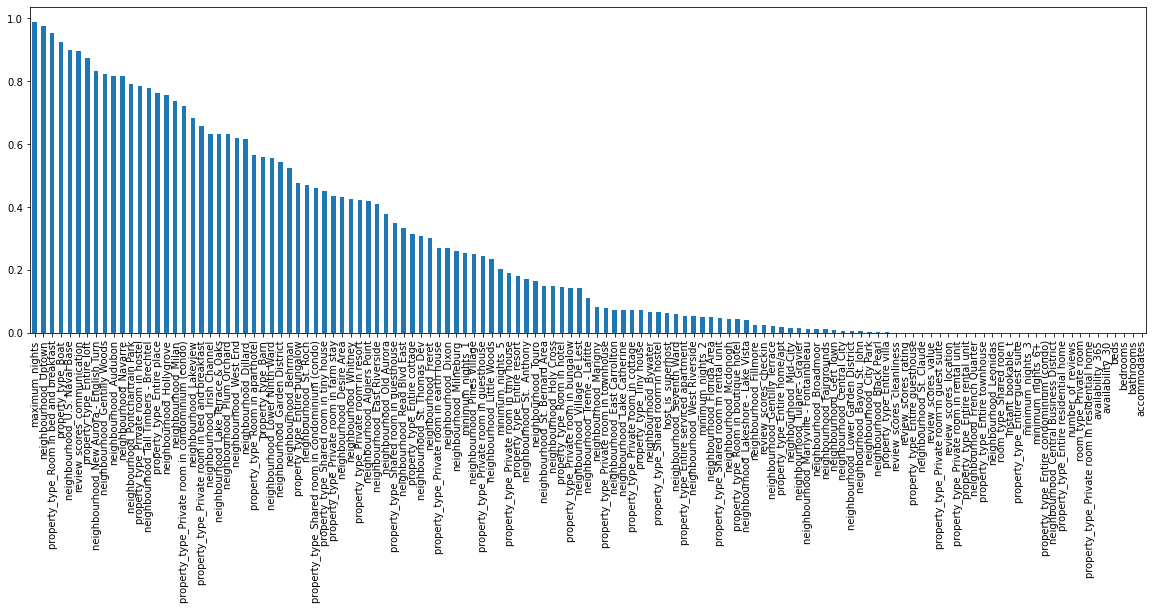

In [37]:
from sklearn.feature_selection import f_classif, f_regression
# Run ANOVA test to get a understanding of possible dependency 
anova = f_regression(X_train, y_train)

# plot values
anova = pd.Series(anova[1])
anova.index = X_train.columns
anova.sort_values(ascending=False).plot.bar(figsize=(20,6))

In [39]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
percentile = SelectPercentile(f_regression,
                        percentile=20).fit(X_train, y_train)

# display selected feature names
precent20_cols = X_train.columns[percentile.get_support()]

In [40]:
precent20_cols 

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30',
       'availability_365', 'number_of_reviews', 'review_scores_location',
       'review_scores_value', 'neighbourhood_Leonidas',
       'neighbourhood_Central Business District',
       'neighbourhood_French Quarter', 'neighbourhood_St. Claude',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Private room in guest suite',
       'property_type_Private room in residential home',
       'property_type_Entire guest suite',
       'property_type_Entire condominium (condo)',
       'property_type_Entire townhouse',
       'property_type_Private room in rental unit', 'room_type_Private room',
       'room_type_Shared room', 'instant_bookable_t', 'minimum_nights_6+',
       'minimum_nights_3'],
      dtype='object')

In [41]:
precent20_train = X_train.drop(precent20_cols, axis=1)
precent20_test = X_test.drop(precent20_cols, axis=1)

In [43]:
def model_diagnostic_sel(model, precent20_test, y_test):
    
    # get prediction on X_test
    test_pred = model.predict(precent20_test)
    
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,0.10417087))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')

In [44]:
precent20 = LinearRegression()
precent20.fit(precent20_train, y_train)

model_diagnostic_sel(precent20, precent20_test, y_test)

Test Mean Absolute Error : 234.24
Test Mean Squared Error: 113189.8
Test Root Mean Square Error :$ 336.44


## Feature selection methods have only hurt our model so far

## Exploring other options
- Could be how we elimnated outliers was not the best way.
- Could be that adding another continous variable would help a lot like add how far from the airport or tourist attractions

In [22]:
from sklearn.decomposition import PCA

In [25]:
pca_model = PCA(n_components=115)

In [26]:
pca_model.fit(X_train)

PCA(n_components=115)

In [27]:
np.sum(pca_model.explained_variance_ratio_)

0.9999999999999997

In [30]:
explained_variance = []

for n in range(1,120):
    
    pca= PCA(n_components=n)
    pca.fit(X_train)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Variance Explained')

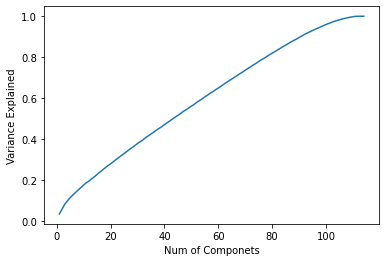

In [31]:
plt.plot(range(1,115), explained_variance)
plt.xlabel('Num of Componets')
plt.ylabel('Variance Explained')

In [32]:
pca_model_95 = PCA(n_components=95)

In [38]:
X_pca = pca_model_95.fit_transform(X_train)

In [35]:
X_pca_test = pca_model_95.transform(X_test)

In [40]:
lr_base.fit(X_pca, y_train)

LinearRegression()

In [42]:
diagnostic_inv(lr_base, X_pca_test, y_test)

Test Mean Absolute Error : 233.27
Test Mean Squared Error: 112042.12
Test Root Mean Square Error :$ 334.73


### Removing neighboorhood data

Over half the columns is neighboorhoods we can see if there is any change if we dont take neighbourhood into account

In [11]:
X_train_DropNBR = X_train[X_train.columns.drop(list(X_train.filter(regex='neighbourhood')))]
X_test_DropNBR = X_test[X_test.columns.drop(list(X_test.filter(regex='neighbourhood')))]

In [12]:
lr_base.fit(X_train_DropNBR, y_train)

diagnostic_inv(lr_base, X_test_DropNBR, y_test)

Test Mean Absolute Error : 232.35
Test Mean Squared Error: 110985.85
Test Root Mean Square Error :$ 333.15


## Results
---
### Understanding why this model isnt good at making predictions

Relevant features: There could not be enough relevant data to build a preductive prediction model. We could try to add more relevant data such as adding more continious features. Some ideas could be distance to the airport, or distance to the top tourist destinations. More features can be added to this model using API to source this data from places such as Google Earth. 

Re-evalutating pre-processing steps: We know from pre-processing that most the continious features were skewed & far from normal. In hopes of making the data more normal I ilimnated outliers using IQR method removing the bottom and top 15% of outliers, this removed ### rows of data. As well, I used boxcox transformations to help with the skewness. Removing outliers is usally a last case sinero, but since this data was so skewed there was a possibility it could help. 

Noise: 

### What can we still learn from this analysis?

## Conclusion
---